In [7]:
import yfinance as yf
import pandas as pd

# List of 40 example tickers
tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA", "JPM", "JNJ", "V",
    "UNH", "HD", "PG", "MA", "BAC", "PFE", "KO", "DIS", "PEP", "INTC",
    "NFLX", "CSCO", "CMCSA", "ABT", "XOM", "T", "CVX", "MCD", "NKE", "ADBE",
    "WMT", "CRM", "ORCL", "IBM", "QCOM", "LLY", "MRK", "BA", "TMO", "COST"
]

# Download 15-minute interval data for the last 60 days (max allowed)
data = yf.download(tickers, period="60d", interval="5m", auto_adjust=False)["Adj Close"]

# Transpose to have each row as one company’s 15-minute interval time series
df = pd.DataFrame(data.transpose())


# At this point, `df` has:
# • Index: the 10 tickers
# • Columns: one column per trading day in the last month
# • Values: adjusted close price for that ticker on that date
df.to_csv("stocks_data.csv")


[*********************100%***********************]  40 of 40 completed


In [14]:
import pandas as pd

df = pd.read_csv("data/stocks_data_noindex.csv")

df.shape
df.iloc[:,-2048:]

2025-04-29 18:35:00+00:00  2025-04-29 18:40:00+00:00  \
0                  211.920105                 211.804993   
1                  131.119995                 131.139999   
2                  371.709991                 371.940002   
3                  187.830002                 187.729996   
4                  182.020004                 182.229996   
5                   40.014999                  40.000000   
6                   33.965000                  33.924999   
7                  990.640015                 989.539978   
8                  267.640015                 267.369202   
9                   57.415001                  57.395000   
10                 139.585007                 139.554993   
11                  91.550003                  91.514999   
12                 160.529907                 160.429993   
13                 359.584991                 359.635010   
14                 239.585007                 239.581894   
15                  20.590000                  20.594999   
16                 156.490005                 156.434998   
17                 245.190002                 244.845001   
18                  72.394997                  72.400002   
19                 891.500000                 891.059998   
20                 538.905029                 538.835022   
21                 315.899994                 315.950012   
22                 556.359924                 555.941223   
23                  84.830101                  84.820000   
24                 394.160004                 393.859497   
25                1121.935059                1121.750854   
26                  57.290001                  57.409901   
27                 109.989998                 110.054497   
28                 140.850006                 140.779999   
29                 133.889999                 133.850006   
30                  23.934999                  23.944401   
31                 161.500000                 161.660004   
32                 148.220001                 148.119995   
33                  27.354799                  27.330000   
34                 428.820007                 428.809998   
35                 285.842712                 285.929993   
36                 411.345001                 411.029999   
37                 341.195007                 341.394989   
38                  95.799896                  95.820000   
39                 108.184998                 108.264999   

    2025-04-29 18:45:00+00:00  2025-04-29 18:50:00+00:00  \
0                  211.550003                 211.460007   
1                  130.985001                 130.970001   
2                  371.690002                 371.600006   
3                  187.600006                 187.520004   
4                  182.009995                 181.970001   
5                   39.994999                  39.990002   
6                   33.930199                  33.934200   
7                  989.715027                 989.380005   
8                  267.394989                 267.630005   
9                   57.375000                  57.384998   
10                 139.449997                 139.485001   
11                  91.470001                  91.449997   
12                 160.365005                 160.315002   
13                 359.195007                 359.209991   
14                 239.580002                 239.619995   
15                  20.565001                  20.555000   
16                 156.350006                 156.320007   
17                 244.634995                 244.537796   
18                  72.360001                  72.404999   
19                 890.415894                 890.369995   
20                 538.525024                 538.315125   
21                 315.465912                 315.510010   
22                 555.840027                 555.900024   
23                  84.781998                  84.739998   
24                 393.750000              

# Stable version

In [ ]:
import io
import gradio as gr
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

torch.manual_seed(42)
output = torch.load("stocks_data_forecast.pt")  # (n_timeseries, pred_len, n_quantiles)

def model_forecast(input_data):
    return output

def plot_forecast_image(timeseries, quantile_predictions, timeseries_name):
    """Returns a NumPy array of the plotted figure."""
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    ax.plot(timeseries, color="blue")
    x_pred = range(len(timeseries) - 1, len(timeseries) - 1 + len(quantile_predictions))
    for i in range(quantile_predictions.shape[1]):
        ax.plot(x_pred, quantile_predictions[:, i], color=f"C{i}")
    buf = io.BytesIO()

    # Add title
    ax.set_title(f"Timeseries: {timeseries_name}")
    # Add labels to the legend (quantiles)
    labels = [f"Quantile {i+1}" for i in range(quantile_predictions.shape[1])]
    ax.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    fig.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return np.array(img)  # Return as an H×W×3 array

def display_forecast(file, preset_filename):
    accepted_formats = ['csv', 'xls', 'xlsx', 'parquet']

    def load_table(file_path):
        ext = file_path.split('.')[-1].lower()
        if ext == 'csv':
            return pd.read_csv(file_path)
        elif ext in ['xls', 'xlsx']:
            return pd.read_excel(file_path)
        elif ext == 'parquet':
            return pd.read_parquet(file_path)
        else:
            raise ValueError(f"Unsupported file format '.{ext}'. Acceptable formats: CSV, XLS, XLSX, PARQUET.")
    
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return [], "Please upload a file or select a preset."
            df = load_table(preset_filename)
        
        # Check first column for timeseries names
        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object:
            if not df.iloc[:, 0].str.isnumeric().all():
                timeseries_names = df.iloc[:, 0].tolist()
                df = df.iloc[:, 1:]
            else:
                timeseries_names = [f"Series {i}" for i in range(len(df))]
        else:
            timeseries_names = [f"Series {i}" for i in range(len(df))]

        _input = torch.tensor(df.values)
        _output = model_forecast(_input)

        gallery_images = []
        for i in range(_input.shape[0]):
            img_array = plot_forecast_image(_input[i], _output[i], timeseries_names[i])
            gallery_images.append(img_array)

        return gallery_images, ""
    except Exception as e:
        return [], f"Error: {e}. Please upload files in one of the following formats: CSV, XLS, XLSX, PARQUET."



iface = gr.Interface(
    fn=display_forecast,
    inputs=[
        gr.File(label="Upload your CSV file (optional)"),
        gr.Dropdown(
            label="Or select a preset CSV file",
            choices=["stocks_data_noindex.csv", "stocks_data.csv"],
            value="stocks_data_noindex.csv"
        )
    ],
    outputs=[
        gr.Gallery(label="Forecast Plots (one per row)"), 
        gr.Textbox(label="Error Message")
    ],
    title="CSV→Dynamic Forecast Gallery",
    description="Upload a CSV with any number of rows; each row’s forecast becomes one image in a gallery.",
    allow_flagging="never",
)

if __name__ == "__main__":
    iface.launch()



# '''
# 1. Prepared datasets
# 2. Plots of different quiantilies (different colors)
# 3. Filters for plots...
# 4. Different input options
# 5. README.md in there (in UI) (contact us for fine-tuning)
# 6. Requirements for dimensions
# 7. Multivariate data (x_t is vector)
# 8. LOGO of NX-AI and xLSTM and tirex
# '''

In [15]:
pd.read_csv("stocks_data.csv")

Ticker  2024-12-04  2024-12-05  2024-12-06  2024-12-09  2024-12-10  \
0   AAPL  242.425201  242.455124  242.255600  246.156204  247.173752   
1   AMZN  218.160004  220.550003  227.029999  226.089996  225.039993   
2  GOOGL  173.970016  172.244003  174.309265  175.168259  184.956985   
3    JNJ  148.006256  147.071823  146.865265  147.150513  146.786560   
4    JPM  240.666992  242.723633  244.582520  241.072388  240.133057   
5   META  612.740173  607.898376  622.713257  612.530518  618.270813   
6   MSFT  435.744720  440.924805  441.871155  444.311768  441.632050   
7   NVDA  145.116653  145.046661  142.426895  138.797226  135.057587   
8   TSLA  357.929993  369.489990  389.220001  389.790009  400.989990   
9      V  308.866455  308.049194  309.972778  307.271790  311.338196   

   2024-12-11  2024-12-12  2024-12-13  2024-12-16  ...  2025-05-21  \
0  245.896820  247.363297  247.532883  250.435867  ...  202.089996   
1  230.259995  228.970001  227.460007  232.929993  ...  201.119995   
2  195.175217  191.739182  189.601639  196.433777  ...  168.559998   
3  144.238968  143.845535  144.219299  141.494659  ...  151.877960   
4  240.795532  238.817978  237.245850  236.889893  ...  261.040009   
5  631.608154  629.721375  619.299072  623.685120  ...  635.500000   
6  447.270416  447.838196  445.556976  449.860413  ...  452.570007   
7  139.297180  137.327362  134.237656  131.987854  ...  131.800003   
8  424.769989  418.100006  436.230011  463.019989  ...  334.619995   
9  312.743500  313.182037  313.690308  314.836517  ...  358.299988   

   2025-05-22  2025-05-23  2025-05-27  2025-05-28  2025-05-29  2025-05-30  \
0  201.360001  195.270004  200.210007  200.419998  199.949997  200.850006   
1  203.100006  200.990005  206.020004  204.720001  205.699997  205.009995   
2  170.869995  168.470001  172.899994  172.360001  171.860001  171.740005   
3  151.312805  151.639999  153.250000  152.429993  153.580002  155.210007   
4  260.670013  260.709991  265.290009  263.489990  264.369995  264.000000   
5  636.570007  627.059998  642.320007  643.580017  645.049988  647.489990   
6  454.859985  450.179993  460.690002  457.359985  458.679993  460.359985   
7  132.830002  131.289993  135.500000  134.809998  139.190002  135.130005   
8  341.040009  339.339996  362.890015  356.899994  358.429993  346.459991   
9  357.970001  353.540009  359.299988  359.730011  362.399994  365.190002   

   2025-06-02  2025-06-03  2025-06-04  
0  201.699997  203.270004  203.150101  
1  206.649994  205.710007  207.472000  
2  169.029999  166.179993  167.785004  
3  155.399994  154.419998  153.419998  
4  264.660004  266.269989  265.065002  
5  670.900024  666.849976  685.159973  
6  461.970001  462.970001  464.190002  
7  137.380005  141.220001  141.854996  
8  342.690002  344.269989  334.671600  
9  365.320007  365.859985  368.179993  

[10 rows x 125 columns]

# Not checked but with labels filter

In [ ]:
import io
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import gradio as gr

# Set random seed and load your pretrained forecast tensor
torch.manual_seed(42)
_forecast_tensor = torch.load("stocks_data_forecast.pt")  # shape = (n_series, pred_len, n_q)

def model_forecast(input_data):
    return _forecast_tensor

def plot_forecast_image(timeseries, quantile_predictions, timeseries_name):
    """Given one 1D series + quantile‐matrix, return a NumPy array of the plotted figure."""
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    ax.plot(timeseries, color="blue")
    x_pred = range(len(timeseries) - 1, len(timeseries) - 1 + len(quantile_predictions))
    for i in range(quantile_predictions.shape[1]):
        ax.plot(x_pred, quantile_predictions[:, i], color=f"C{i}")
    ax.set_title(f"Timeseries: {timeseries_name}")

    labels = [f"Quantile {i}" for i in range(quantile_predictions.shape[1])]
    ax.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return np.array(img)

def load_table(file_path):
    """Load CSV / XLS(X) / Parquet by extension, else raise."""
    ext = file_path.split(".")[-1].lower()
    if ext == "csv":
        return pd.read_csv(file_path)
    elif ext in ("xls", "xlsx"):
        return pd.read_excel(file_path)
    elif ext == "parquet":
        return pd.read_parquet(file_path)
    else:
        raise ValueError(
            f"Unsupported file format '.{ext}'. Accepted: CSV, XLS, XLSX, PARQUET."
        )

def extract_names_and_update(file, preset_filename):
    """
    Read the table (uploaded or preset), extract timeseries names, and return:
    1) gr.update for the CheckboxGroup (all names pre‐checked)
    2) the full list of names to store in state.
    """
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return gr.update(choices=[], value=[]), []
            df = load_table(preset_filename)

        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object and not df.iloc[:, 0].str.isnumeric().all():
            names = df.iloc[:, 0].tolist()
        else:
            names = [f"Series {i}" for i in range(len(df))]

        return gr.update(choices=names, value=names), names
    except Exception:
        return gr.update(choices=[], value=[]), []

def filter_names(search_term, all_names):
    """
    Filter the full list of names (all_names) by the search_term (case‐insensitive substring).
    Return gr.update with filtered choices and keep checked those that remain in both.
    """
    if not all_names:
        return gr.update(choices=[], value=[])
    if not search_term:
        # No search term → show all
        return gr.update(choices=all_names, value=all_names)
    lower = search_term.lower()
    filtered = [n for n in all_names if lower in str(n).lower()]
    return gr.update(choices=filtered, value=filtered)

def check_all(names_list):
    """Return an update that checks all names in the checkbox."""
    return gr.update(value=names_list)

def uncheck_all(_):
    """Return an update that unchecks all names."""
    return gr.update(value=[])

def display_filtered_forecast(file, preset_filename, selected_names):
    """
    Load the table, filter by selected_names, run forecast, and return:
    - list of images (NumPy arrays) for the gallery
    - error string (empty if OK)
    """
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return [], "No file selected."
            df = load_table(preset_filename)

        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object and not df.iloc[:, 0].str.isnumeric().all():
            all_names = df.iloc[:, 0].tolist()
            data_only = df.iloc[:, 1:].astype(float)
        else:
            all_names = [f"Series {i}" for i in range(len(df))]
            data_only = df.astype(float)

        mask = [name in selected_names for name in all_names]
        if not any(mask):
            return [], "No timeseries chosen to plot."

        filtered_data = data_only.iloc[mask, :].values
        filtered_names = [all_names[i] for i, m in enumerate(mask) if m]

        inp = torch.tensor(filtered_data)           # (n_chosen, length)
        out = model_forecast(inp)                   # (n_chosen, pred_len, n_q)

        gallery_images = []
        for i in range(inp.shape[0]):
            gallery_images.append(
                plot_forecast_image(inp[i], out[i], filtered_names[i])
            )

        return gallery_images, ""
    except Exception as e:
        return [], f"Error: {e}. Please upload a valid CSV, XLS, XLSX, or PARQUET file."

with gr.Blocks() as demo:
    gr.Markdown("## Upload or select a preset → search/filter by name → click Plot")

    with gr.Row():
        file_input = gr.File(
            label="Upload CSV/XLSX/PARQUET (optional)",
            file_types=[".csv", ".xls", ".xlsx", ".parquet"]
        )
        preset_dropdown = gr.Dropdown(
            label="Or pick a preset:",
            choices=["stocks_data_noindex.csv", "stocks_data.csv"],
            value="stocks_data_noindex.csv"
        )

    # A text box to type a substring (search term)
    search_box = gr.Textbox(
        label="Search/Filter timeseries by name",
        placeholder="Type to filter (e.g. 'AMZN')",
        value=""
    )

    # A CheckboxGroup to show matching names; choices/value will be updated dynamically
    filter_checkbox = gr.CheckboxGroup(
        choices=[], value=[], label="Select which timeseries to show"
    )

    # Buttons to check or uncheck all
    with gr.Row():
        check_all_btn = gr.Button("Check All")
        uncheck_all_btn = gr.Button("Uncheck All")

    plot_button = gr.Button("Plot")

    gallery = gr.Gallery(label="Forecast Plots (filtered)")
    errbox = gr.Textbox(label="Error Message")

    # State to hold the full list of names
    names_state = gr.State([])

    # 1) When file or preset changes, extract full names and update the checkbox + state
    file_input.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )
    preset_dropdown.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )

    # 2) When search text changes, filter names_state and update the checkbox
    search_box.change(
        fn=filter_names,
        inputs=[search_box, names_state],
        outputs=filter_checkbox
    )

    # 3) Check All button: set checkbox value to all names in state
    check_all_btn.click(
        fn=check_all,
        inputs=names_state,
        outputs=filter_checkbox
    )

    # 4) Uncheck All button: set checkbox value to empty list
    uncheck_all_btn.click(
        fn=uncheck_all,
        inputs=names_state,
        outputs=filter_checkbox
    )

    # 5) When "Plot" is clicked, generate the filtered plots
    plot_button.click(
        fn=display_filtered_forecast,
        inputs=[file_input, preset_dropdown, filter_checkbox],
        outputs=[gallery, errbox],
    )

demo.launch()



# Checked, filter

In [ ]:
import io
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import gradio as gr

# ----------------------------
# Helper functions (logic unchanged)
# ----------------------------

torch.manual_seed(42)
_forecast_tensor = torch.load("stocks_data_forecast.pt")  # shape = (n_series, pred_len, n_q)

def model_forecast(input_data):
    return _forecast_tensor

def plot_forecast_image(timeseries, quantile_predictions, timeseries_name):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    ax.plot(timeseries, color="blue")
    x_pred = range(len(timeseries) - 1, len(timeseries) - 1 + len(quantile_predictions))
    for i in range(quantile_predictions.shape[1]):
        ax.plot(x_pred, quantile_predictions[:, i], color=f"C{i}")
    ax.set_title(f"Timeseries: {timeseries_name}")
    labels = [f"Quantile {i}" for i in range(quantile_predictions.shape[1])]
    ax.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return np.array(img)

def load_table(file_path):
    ext = file_path.split(".")[-1].lower()
    if ext == "csv":
        return pd.read_csv(file_path)
    elif ext in ("xls", "xlsx"):
        return pd.read_excel(file_path)
    elif ext == "parquet":
        return pd.read_parquet(file_path)
    else:
        raise ValueError("Unsupported format. Use CSV, XLS, XLSX, or PARQUET.")

def extract_names_and_update(file, preset_filename):
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return gr.update(choices=[], value=[]), []
            df = load_table(preset_filename)

        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object and not df.iloc[:, 0].str.isnumeric().all():
            names = df.iloc[:, 0].tolist()
        else:
            names = [f"Series {i}" for i in range(len(df))]
        return gr.update(choices=names, value=names), names
    except Exception:
        return gr.update(choices=[], value=[]), []

def filter_names(search_term, all_names):
    if not all_names:
        return gr.update(choices=[], value=[])
    if not search_term:
        return gr.update(choices=all_names, value=all_names)
    lower = search_term.lower()
    filtered = [n for n in all_names if lower in str(n).lower()]
    return gr.update(choices=filtered, value=filtered)

def check_all(names_list):
    return gr.update(value=names_list)

def uncheck_all(_):
    return gr.update(value=[])

def display_filtered_forecast(file, preset_filename, selected_names):
    """
    Load the table, filter by selected_names, run forecast (correctly sliced),
    and return a gallery + error string.
    """
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return [], "No file selected."
            df = load_table(preset_filename)

        # Extract all_names and numeric data
        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object \
           and not df.iloc[:, 0].str.isnumeric().all():
            all_names = df.iloc[:, 0].tolist()
            data_only = df.iloc[:, 1:].astype(float)
        else:
            all_names = [f"Series {i}" for i in range(len(df))]
            data_only = df.astype(float)

        # Build mask and filtered subset
        mask = [name in selected_names for name in all_names]
        if not any(mask):
            return [], "No timeseries chosen to plot."

        filtered_data = data_only.iloc[mask, :].values
        filtered_names = [all_names[i] for i, m in enumerate(mask) if m]

        # ------------------------
        # HERE is the only change:
        # Instead of calling model_forecast(inp), slice the full tensor by mask:
        # ------------------------
        out = _forecast_tensor[mask]   # shape = (n_chosen, pred_len, n_q)
        inp = torch.tensor(filtered_data)

        # Plot each chosen series against its properly‐aligned forecast
        gallery_images = []
        for i in range(inp.shape[0]):
            gallery_images.append(
                plot_forecast_image(inp[i], out[i], filtered_names[i])
            )

        return gallery_images, ""
    except Exception as e:
        return [], f"Error: {e}. Please upload a valid CSV, XLS, XLSX, or PARQUET file."


# ----------------------------
# Gradio layout: two columns
# ----------------------------

with gr.Blocks() as demo:
    gr.Markdown("# 📈 Stock Forecast Viewer 📊")
    gr.Markdown("Upload data or choose a preset, filter by name, then click Plot.")

    with gr.Row():
        # Left column: controls
        with gr.Column():
            gr.Markdown("## Data Selection")
            file_input = gr.File(
                label="Upload CSV / XLSX / PARQUET",
                file_types=[".csv", ".xls", ".xlsx", ".parquet"]
            )
            preset_dropdown = gr.Dropdown(
                label="Or choose a preset:",
                choices=["stocks_data_noindex.csv", "stocks_data.csv"],
                value="stocks_data_noindex.csv"
            )

            gr.Markdown("## Search / Filter")
            search_box = gr.Textbox(
                placeholder="Type to filter (e.g. 'AMZN')"
            )
            filter_checkbox = gr.CheckboxGroup(
                choices=[], value=[], label="Select which timeseries to show"
            )

            with gr.Row():
                check_all_btn = gr.Button("✅ Check All")
                uncheck_all_btn = gr.Button("❎ Uncheck All")

            plot_button = gr.Button("▶️ Plot Forecasts")
            errbox = gr.Textbox(interactive=False, placeholder="")

        # Right column: gallery
        with gr.Column():
            gr.Markdown("## Forecast Gallery")
            gallery = gr.Gallery()

    names_state = gr.State([])

    # When file or preset changes, update names
    file_input.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )
    preset_dropdown.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )

    # When search term changes, filter names
    search_box.change(
        fn=filter_names,
        inputs=[search_box, names_state],
        outputs=filter_checkbox
    )

    # Check All / Uncheck All
    check_all_btn.click(fn=check_all, inputs=names_state, outputs=filter_checkbox)
    uncheck_all_btn.click(fn=uncheck_all, inputs=names_state, outputs=filter_checkbox)

    # Plot button
    plot_button.click(
        fn=display_filtered_forecast,
        inputs=[file_input, preset_dropdown, filter_checkbox],
        outputs=[gallery, errbox]
    )

demo.launch()

# Checked, almost ideal

In [ ]:
import io
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import gradio as gr

# ----------------------------
# Helper functions (logic unchanged)
# ----------------------------

torch.manual_seed(42)
_forecast_tensor = torch.load("stocks_data_forecast.pt")  # shape = (n_series, pred_len, n_q)

def model_forecast(input_data):
    return _forecast_tensor

def plot_forecast_image(timeseries, quantile_predictions, timeseries_name):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    ax.plot(timeseries, color="blue")
    x_pred = range(len(timeseries) - 1, len(timeseries) - 1 + len(quantile_predictions))
    for i in range(quantile_predictions.shape[1]):
        ax.plot(x_pred, quantile_predictions[:, i], color=f"C{i}")
    ax.set_title(f"Timeseries: {timeseries_name}")
    labels = [f"Quantile {i}" for i in range(quantile_predictions.shape[1])]
    ax.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return np.array(img)

def load_table(file_path):
    ext = file_path.split(".")[-1].lower()
    if ext == "csv":
        return pd.read_csv(file_path)
    elif ext in ("xls", "xlsx"):
        return pd.read_excel(file_path)
    elif ext == "parquet":
        return pd.read_parquet(file_path)
    else:
        raise ValueError("Unsupported format. Use CSV, XLS, XLSX, or PARQUET.")

def extract_names_and_update(file, preset_filename):
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return gr.update(choices=[], value=[]), []
            df = load_table(preset_filename)

        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object and not df.iloc[:, 0].str.isnumeric().all():
            names = df.iloc[:, 0].tolist()
        else:
            names = [f"Series {i}" for i in range(len(df))]
        return gr.update(choices=names, value=names), names
    except Exception:
        return gr.update(choices=[], value=[]), []

def filter_names(search_term, all_names):
    if not all_names:
        return gr.update(choices=[], value=[])
    if not search_term:
        return gr.update(choices=all_names, value=all_names)
    lower = search_term.lower()
    filtered = [n for n in all_names if lower in str(n).lower()]
    return gr.update(choices=filtered, value=filtered)

def check_all(names_list):
    return gr.update(value=names_list)

def uncheck_all(_):
    return gr.update(value=[])

def display_filtered_forecast(file, preset_filename, selected_names):
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return [], "No file selected."
            df = load_table(preset_filename)

        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object and not df.iloc[:, 0].str.isnumeric().all():
            all_names = df.iloc[:, 0].tolist()
            data_only = df.iloc[:, 1:].astype(float)
        else:
            all_names = [f"Series {i}" for i in range(len(df))]
            data_only = df.astype(float)

        mask = [name in selected_names for name in all_names]
        if not any(mask):
            return [], "No timeseries chosen to plot."

        filtered_data = data_only.iloc[mask, :].values
        filtered_names = [all_names[i] for i, m in enumerate(mask) if m]
        out = _forecast_tensor[mask]   # slice forecasts to match filtered rows
        inp = torch.tensor(filtered_data)

        gallery_images = []
        for i in range(inp.shape[0]):
            gallery_images.append(plot_forecast_image(inp[i], out[i], filtered_names[i]))

        return gallery_images, ""
    except Exception as e:
        return [], f"Error: {e}. Use CSV, XLS, XLSX, or PARQUET."

# ----------------------------
# Gradio layout: two columns + instructions
# ----------------------------

with gr.Blocks() as demo:
    gr.Markdown("# 📈 Stock Forecast Viewer 📊")
    gr.Markdown("Upload data or choose a preset, filter by name, then click Plot.")

    with gr.Row():
        # Left column: controls
        with gr.Column():
            gr.Markdown("## Data Selection")
            file_input = gr.File(
                label="Upload CSV / XLSX / PARQUET",
                file_types=[".csv", ".xls", ".xlsx", ".parquet"]
            )
            preset_dropdown = gr.Dropdown(
                label="Or choose a preset:",
                choices=["stocks_data_noindex.csv", "stocks_data.csv"],
                value="stocks_data_noindex.csv"
            )

            gr.Markdown("## Search / Filter")
            search_box = gr.Textbox(placeholder="Type to filter (e.g. 'AMZN')")
            filter_checkbox = gr.CheckboxGroup(
                choices=[], value=[], label="Select which timeseries to show"
            )

            with gr.Row():
                check_all_btn = gr.Button("✅ Check All")
                uncheck_all_btn = gr.Button("❎ Uncheck All")

            plot_button = gr.Button("▶️ Plot Forecasts")
            errbox = gr.Textbox(interactive=False, placeholder="")

        # Right column: gallery + instructions
        with gr.Column():
            gr.Markdown("## Forecast Gallery")
            gallery = gr.Gallery()

            # Instruction text below gallery
            gr.Markdown(
                """
                **How to format your data:**
                - Your file must be a table (CSV, XLS, XLSX, or Parquet).
                - If you haven't prepared the data, the preset file will be used.
                - **One row per timeseries.** Each row is treated as a separate series.
                - If you want to **name** each series, put the name as the first value in **every** row:
                  - Example (CSV):  
                    `AAPL, 120.5, 121.0, 119.8, ...`  
                    `AMZN, 3300.0, 3310.5, 3295.2, ...`  
                  - In that case, the first column is not numeric, so it will be used as the series name.
                - If you do **not** want named series, simply leave out the first column entirely and have all values numeric:
                  - Example:  
                    `120.5, 121.0, 119.8, ...`  
                    `3300.0, 3310.5, 3295.2, ...`  
                  - Then every row will be auto-named “Series 0, Series 1, …” in order.
                - **Consistency rule:** Either all rows have a non-numeric first entry for the name, or none do. Do not mix.
                - The rest of the columns (after the optional name) must be numeric data points for that series.
                - You can filter by typing in the search box. Then check or uncheck individual names before plotting.
                - Use “Check All” / “Uncheck All” to quickly select or deselect every series.
                - Finally, click **Plot Forecasts** to view the quantile forecast for each selected series.
                """
            )

    names_state = gr.State([])

    # When file or preset changes, update names
    file_input.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )
    preset_dropdown.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )

    # When search term changes, filter names
    search_box.change(
        fn=filter_names,
        inputs=[search_box, names_state],
        outputs=filter_checkbox
    )

    # Check All / Uncheck All
    check_all_btn.click(fn=check_all, inputs=names_state, outputs=filter_checkbox)
    uncheck_all_btn.click(fn=uncheck_all, inputs=names_state, outputs=filter_checkbox)

    # Plot button
    plot_button.click(
        fn=display_filtered_forecast,
        inputs=[file_input, preset_dropdown, filter_checkbox],
        outputs=[gallery, errbox]
    )

demo.launch()

# The default choice isn't processed when the default choice is chosen

In [ ]:
import io
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import gradio as gr

# ----------------------------
# Helper functions (logic unchanged)
# ----------------------------

torch.manual_seed(42)
_forecast_tensor = torch.load("stocks_data_forecast.pt")  # shape = (n_series, pred_len, n_q)

def model_forecast(input_data):
    return _forecast_tensor

def plot_forecast_image(timeseries, quantile_predictions, timeseries_name):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    ax.plot(timeseries, color="blue")
    x_pred = range(len(timeseries) - 1, len(timeseries) - 1 + len(quantile_predictions))
    for i in range(quantile_predictions.shape[1]):
        ax.plot(x_pred, quantile_predictions[:, i], color=f"C{i}")
    ax.set_title(f"Timeseries: {timeseries_name}")
    labels = [f"Quantile {i}" for i in range(quantile_predictions.shape[1])]
    ax.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return np.array(img)

def load_table(file_path):
    ext = file_path.split(".")[-1].lower()
    if ext == "csv":
        return pd.read_csv(file_path)
    elif ext in ("xls", "xlsx"):
        return pd.read_excel(file_path)
    elif ext == "parquet":
        return pd.read_parquet(file_path)
    else:
        raise ValueError("Unsupported format. Use CSV, XLS, XLSX, or PARQUET.")

def extract_names_and_update(file, preset_filename):
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return gr.update(choices=[], value=[]), []
            df = load_table(preset_filename)

        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object and not df.iloc[:, 0].str.isnumeric().all():
            names = df.iloc[:, 0].tolist()
        else:
            names = [f"Series {i}" for i in range(len(df))]
        return gr.update(choices=names, value=names), names
    except Exception:
        return gr.update(choices=[], value=[]), []

def filter_names(search_term, all_names):
    if not all_names:
        return gr.update(choices=[], value=[])
    if not search_term:
        return gr.update(choices=all_names, value=all_names)
    lower = search_term.lower()
    filtered = [n for n in all_names if lower in str(n).lower()]
    return gr.update(choices=filtered, value=filtered)

def check_all(names_list):
    return gr.update(value=names_list)

def uncheck_all(_):
    return gr.update(value=[])

def display_filtered_forecast(file, preset_filename, selected_names):
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return [], "No file selected."
            df = load_table(preset_filename)

        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object and not df.iloc[:, 0].str.isnumeric().all():
            all_names = df.iloc[:, 0].tolist()
            data_only = df.iloc[:, 1:].astype(float)
        else:
            all_names = [f"Series {i}" for i in range(len(df))]
            data_only = df.astype(float)

        mask = [name in selected_names for name in all_names]
        if not any(mask):
            return [], "No timeseries chosen to plot."

        filtered_data = data_only.iloc[mask, :].values
        filtered_names = [all_names[i] for i, m in enumerate(mask) if m]
        out = _forecast_tensor[mask]   # slice forecasts to match filtered rows
        inp = torch.tensor(filtered_data)

        gallery_images = []
        for i in range(inp.shape[0]):
            gallery_images.append(plot_forecast_image(inp[i], out[i], filtered_names[i]))

        return gallery_images, ""
    except Exception as e:
        return [], f"Error: {e}. Use CSV, XLS, XLSX, or PARQUET."


# ----------------------------
# Gradio layout: two columns + instructions
# ----------------------------

with gr.Blocks() as demo:
    gr.Markdown("# 📈 Stock Forecast Viewer 📊")
    gr.Markdown("Upload data or choose a preset, filter by name, then click Plot.")

    with gr.Row():
        # Left column: controls
        with gr.Column():
            gr.Markdown("## Data Selection")
            gr.Markdown("*If you haven't prepared the data, the preset file will be used.*")
            file_input = gr.File(
                label="Upload CSV / XLSX / PARQUET",
                file_types=[".csv", ".xls", ".xlsx", ".parquet"]
            )
            preset_dropdown = gr.Dropdown(
                label="Or choose a preset:",
                choices=["stocks_data_noindex.csv", "stocks_data.csv"],
                value="stocks_data_noindex.csv"
            )

            gr.Markdown("## Search / Filter")
            search_box = gr.Textbox(placeholder="Type to filter (e.g. 'AMZN')")
            filter_checkbox = gr.CheckboxGroup(
                choices=[], value=[], label="Select which timeseries to show"
            )

            with gr.Row():
                check_all_btn = gr.Button("✅ Check All")
                uncheck_all_btn = gr.Button("❎ Uncheck All")

            plot_button = gr.Button("▶️ Plot Forecasts")
            errbox = gr.Textbox(label="Error Message", interactive=False)

        # Right column: gallery + instructions
        with gr.Column():
            gr.Markdown("## Forecast Gallery")
            gallery = gr.Gallery()

            # Instruction text below gallery
            gr.Markdown(
                """
                **How to format your data:**
                - Your file must be a table (CSV, XLS, XLSX, or Parquet).
                - **One row per timeseries.** Each row is treated as a separate series.
                - If you want to **name** each series, put the name as the first value in **every** row:
                  - Example (CSV):  
                    `AAPL, 120.5, 121.0, 119.8, ...`  
                    `AMZN, 3300.0, 3310.5, 3295.2, ...`  
                  - In that case, the first column is not numeric, so it will be used as the series name.
                - If you do **not** want named series, simply leave out the first column entirely and have all values numeric:
                  - Example:  
                    `120.5, 121.0, 119.8, ...`  
                    `3300.0, 3310.5, 3295.2, ...`  
                  - Then every row will be auto-named “Series 0, Series 1, …” in order.
                - **Consistency rule:** Either all rows have a non-numeric first entry for the name, or none do. Do not mix.
                - The rest of the columns (after the optional name) must be numeric data points for that series.
                - You can filter by typing in the search box. Then check or uncheck individual names before plotting.
                - Use “Check All” / “Uncheck All” to quickly select or deselect every series.
                - Finally, click **Plot Forecasts** to view the quantile forecast for each selected series.
                """
            )

    names_state = gr.State([])

    # When file or preset changes, update names
    file_input.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )
    preset_dropdown.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )

    # When search term changes, filter names
    search_box.change(
        fn=filter_names,
        inputs=[search_box, names_state],
        outputs=filter_checkbox
    )

    # Check All / Uncheck All
    check_all_btn.click(fn=check_all, inputs=names_state, outputs=filter_checkbox)
    uncheck_all_btn.click(fn=uncheck_all, inputs=names_state, outputs=filter_checkbox)

    # Plot button
    plot_button.click(
        fn=display_filtered_forecast,
        inputs=[file_input, preset_dropdown, filter_checkbox],
        outputs=[gallery, errbox]
    )

demo.launch()

# Default choice - None

In [ ]:
import io
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import gradio as gr

# ----------------------------
# Helper functions (logic unchanged)
# ----------------------------

torch.manual_seed(42)
_forecast_tensor = torch.load("stocks_data_forecast.pt")  # shape = (n_series, pred_len, n_q)

def model_forecast(input_data):
    return _forecast_tensor

def plot_forecast_image(timeseries, quantile_predictions, timeseries_name):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    
    # Plot the original timeseries with thicker line and marker
    ax.plot(timeseries, color="blue", linewidth=2.5, marker='o', label="Given Data")
    
    x_pred = range(len(timeseries) - 1, len(timeseries) - 1 + len(quantile_predictions))
    # Use distinct colors with higher alpha for smoothness
    for i in range(quantile_predictions.shape[1]):
        ax.plot(x_pred, quantile_predictions[:, i], color=f"C{i}", linewidth=2, alpha=0.8, label=f"Quantile {i+1}")
    
    ax.set_title(f"Timeseries: {timeseries_name}", fontsize=16, fontweight='bold')
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10, frameon=True, shadow=True)
    
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", transparent=True)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return np.array(img)

def load_table(file_path):
    ext = file_path.split(".")[-1].lower()
    if ext == "csv":
        return pd.read_csv(file_path)
    elif ext in ("xls", "xlsx"):
        return pd.read_excel(file_path)
    elif ext == "parquet":
        return pd.read_parquet(file_path)
    else:
        raise ValueError("Unsupported format. Use CSV, XLS, XLSX, or PARQUET.")

def extract_names_and_update(file, preset_filename):
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return gr.update(choices=[], value=[]), []
            df = load_table(preset_filename)

        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object and not df.iloc[:, 0].str.isnumeric().all():
            names = df.iloc[:, 0].tolist()
        else:
            names = [f"Series {i}" for i in range(len(df))]
        return gr.update(choices=names, value=names), names
    except Exception:
        return gr.update(choices=[], value=[]), []

def filter_names(search_term, all_names):
    if not all_names:
        return gr.update(choices=[], value=[])
    if not search_term:
        return gr.update(choices=all_names, value=all_names)
    lower = search_term.lower()
    filtered = [n for n in all_names if lower in str(n).lower()]
    return gr.update(choices=filtered, value=filtered)

def check_all(names_list):
    return gr.update(value=names_list)

def uncheck_all(_):
    return gr.update(value=[])

def display_filtered_forecast(file, preset_filename, selected_names):
    try:
        if file is not None:
            df = load_table(file.name)
        else:
            if not preset_filename:
                return [], "No file selected."
            df = load_table(preset_filename)

        if df.shape[1] > 0 and df.iloc[:, 0].dtype == object and not df.iloc[:, 0].str.isnumeric().all():
            all_names = df.iloc[:, 0].tolist()
            data_only = df.iloc[:, 1:].astype(float)
        else:
            all_names = [f"Series {i}" for i in range(len(df))]
            data_only = df.astype(float)

        mask = [name in selected_names for name in all_names]
        if not any(mask):
            return [], "No timeseries chosen to plot."

        filtered_data = data_only.iloc[mask, :].values
        filtered_names = [all_names[i] for i, m in enumerate(mask) if m]
        out = _forecast_tensor[mask]   # slice forecasts to match filtered rows
        inp = torch.tensor(filtered_data)

        gallery_images = []
        for i in range(inp.shape[0]):
            gallery_images.append(plot_forecast_image(inp[i], out[i], filtered_names[i]))

        return gallery_images, ""
    except Exception as e:
        return [], f"Error: {e}. Use CSV, XLS, XLSX, or PARQUET."


# ----------------------------
# Gradio layout: two columns + instructions
# ----------------------------

with gr.Blocks() as demo:
    gr.Markdown("# 📈 Stock Forecast Viewer 📊")
    gr.Markdown("Upload data or choose a preset, filter by name, then click Plot.")

    with gr.Row():
        # Left column: controls
        with gr.Column():
            gr.Markdown("## Data Selection")
            file_input = gr.File(
                label="Upload CSV / XLSX / PARQUET",
                file_types=[".csv", ".xls", ".xlsx", ".parquet"]
            )
            preset_dropdown = gr.Dropdown(
                label="Or choose a preset:",
                choices=["stocks_data_noindex.csv", "stocks_data.csv"],
                value="No file selected"
            )

            gr.Markdown("## Search / Filter")
            search_box = gr.Textbox(placeholder="Type to filter (e.g. 'AMZN')")
            filter_checkbox = gr.CheckboxGroup(
                choices=[], value=[], label="Select which timeseries to show"
            )

            with gr.Row():
                check_all_btn = gr.Button("✅ Check All")
                uncheck_all_btn = gr.Button("❎ Uncheck All")

            plot_button = gr.Button("▶️ Plot Forecasts")
            errbox = gr.Textbox(label="Error Message", interactive=False)

        # Right column: gallery + instructions
        with gr.Column():
            gr.Markdown("## Forecast Gallery")
            gallery = gr.Gallery()

            # Instruction text below gallery
            gr.Markdown("## Instructions")
            gr.Markdown(
                """
                **How to format your data:**
                - Your file must be a table (CSV, XLS, XLSX, or Parquet).
                - **One row per timeseries.** Each row is treated as a separate series.
                - If you want to **name** each series, put the name as the first value in **every** row:
                  - Example (CSV):  
                    `AAPL, 120.5, 121.0, 119.8, ...`  
                    `AMZN, 3300.0, 3310.5, 3295.2, ...`  
                  - In that case, the first column is not numeric, so it will be used as the series name.
                - If you do **not** want named series, simply leave out the first column entirely and have all values numeric:
                  - Example:  
                    `120.5, 121.0, 119.8, ...`  
                    `3300.0, 3310.5, 3295.2, ...`  
                  - Then every row will be auto-named “Series 0, Series 1, …” in order.
                - **Consistency rule:** Either all rows have a non-numeric first entry for the name, or none do. Do not mix.
                - The rest of the columns (after the optional name) must be numeric data points for that series.
                - You can filter by typing in the search box. Then check or uncheck individual names before plotting.
                - Use “Check All” / “Uncheck All” to quickly select or deselect every series.
                - Finally, click **Plot Forecasts** to view the quantile forecast for each selected series.
                """
            )

    names_state = gr.State([])

    # When file or preset changes, update names
    file_input.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )
    preset_dropdown.change(
        fn=extract_names_and_update,
        inputs=[file_input, preset_dropdown],
        outputs=[filter_checkbox, names_state]
    )

    # When search term changes, filter names
    search_box.change(
        fn=filter_names,
        inputs=[search_box, names_state],
        outputs=filter_checkbox
    )

    # Check All / Uncheck All
    check_all_btn.click(fn=check_all, inputs=names_state, outputs=filter_checkbox)
    uncheck_all_btn.click(fn=uncheck_all, inputs=names_state, outputs=filter_checkbox)

    # Plot button
    plot_button.click(
        fn=display_filtered_forecast,
        inputs=[file_input, preset_dropdown, filter_checkbox],
        outputs=[gallery, errbox]
    )

demo.launch()

In [ ]:
# maybe some sanity checks in regard to the input would be good
# maxium of idk maybe 30? variates (to save compute and avoid visualization problems)   -> with just sending error messages when more thant that are in the input file
# series longer than 2048 we can cut off (tirex is anyway doing that internally)
# apart from that maybe check with 
# @Elias Bürger
#  how one then can set this up in hugginface (if there are open questions)  - it would be cool if it would be possible to set it up first "private" so that we can test it on hugginface and then set it public afterwards (edited) 

# '''
# 8. *Range of prediction length customizable 
# 9. *Multivariate data (x_t is vector)
# '''

In [24]:
torch.load('data/air_passengers_forecast_256.pt').shape, torch.load('data/merged_ett2_loop_forecast_256.pt').shape

(torch.Size([1, 256, 9]), torch.Size([4, 256, 9]))

In [26]:
pd.read_csv('data/air_passangers.csv')

index      0      1      2      3      4      5      6      7  \
0  air_passangers  132.0  129.0  121.0  135.0  148.0  148.0  136.0  119.0   

       8  ...    132    133    134    135    136    137    138    139    140  \
0  104.0  ...  419.0  461.0  472.0  535.0  622.0  606.0  508.0  461.0  390.0   

     141  
0  432.0  

[1 rows x 143 columns]

In [27]:
pd.read_csv('data/merged_ett2_loop.csv')

Unnamed: 0          0          1          2          3          4  \
0     ett2_2  25.214001  21.193001  19.601999  22.617001  25.884001   
1     ett2_5  12.649000  13.068000  13.403000  12.733000  12.481000   
2     loop_6  54.271523  56.406818  55.328819  52.330349  54.279472   
3     loop_7  58.644505  52.885113  54.297569  55.952805  60.136642   

           5          6          7          8  ...       2517       2518  \
0  25.549000  24.628000  23.287001  22.701000  ...  31.329000  28.565001   
1  13.068000  11.895000  11.644000  11.225000  ...  33.005001  31.413000   
2  55.758884  55.381527  56.369274  54.589359  ...  58.924488  60.137211   
3  60.026550  53.077511  53.965748  57.957455  ...  63.770260  63.091949   

        2519       2520       2521       2522       2523       2524  \
0  32.585999  32.167000  30.240000  30.073000  29.989000  29.486000   
1  29.820999  30.073000  32.585999  30.827000  27.476000  28.565001   
2  59.653061  56.785187  58.367878  55.989887  56.791931  56.689064   
3  62.029819  62.587704  64.200348  63.076702  64.517593  64.431839   

        2525       2526  
0  31.329000  32.417999  
1  31.329000  31.747999  
2  56.753975  57.298767  
3  62.695835  64.302551  

[4 rows x 2528 columns]

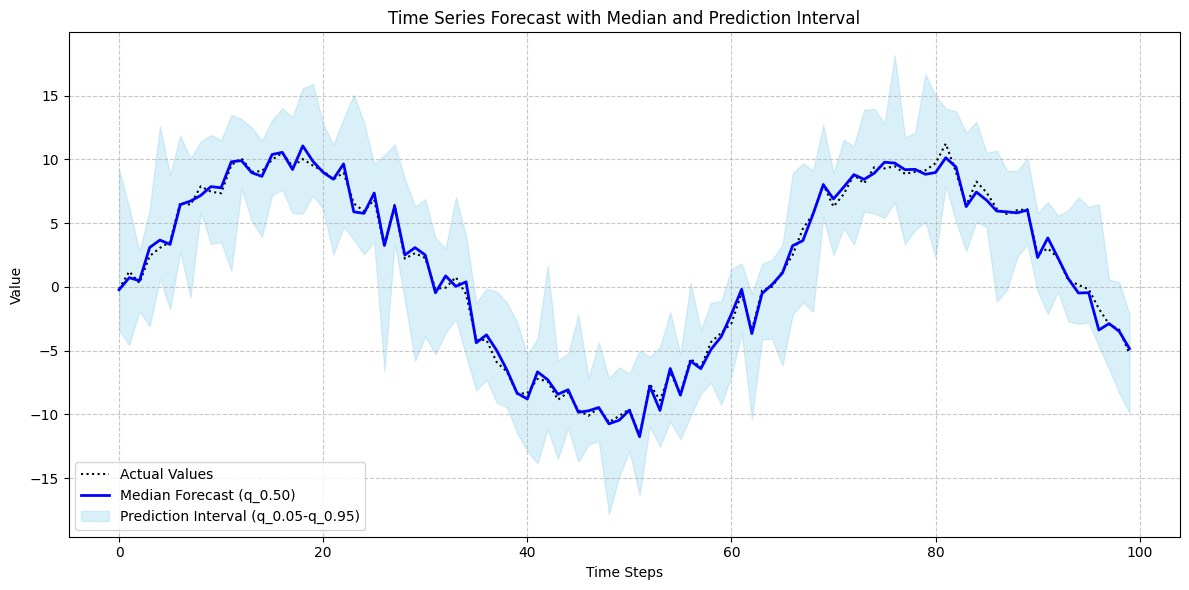

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Generate Sample Data (Replace with your actual data) ---
# Let's imagine a time series of 100 steps
time_steps = np.arange(100)

# Actual values (optional, for context)
actual_values = pd.Series(np.sin(time_steps / 10) * 10 + np.random.normal(0, 1, 100), index=time_steps)

# Quantile predictions from your LSTLM
# For demonstration, we'll create some plausible quantile forecasts
# In a real scenario, these would be the output of your model
data = {}
data['q_0.05'] = actual_values - np.abs(np.random.normal(0, 3, 100)) - 2
data['q_0.25'] = actual_values - np.abs(np.random.normal(0, 1.5, 100)) - 1
data['q_0.50'] = actual_values + np.random.normal(0, 0.5, 100) # Median forecast
data['q_0.75'] = actual_values + np.abs(np.random.normal(0, 1.5, 100)) + 1
data['q_0.95'] = actual_values + np.abs(np.random.normal(0, 3, 100)) + 2

# Ensure the quantiles are ordered correctly (lower < median < upper)
data['q_0.05'] = np.minimum(data['q_0.05'], data['q_0.25'])
data['q_0.25'] = np.minimum(data['q_0.25'], data['q_0.50'])
data['q_0.95'] = np.maximum(data['q_0.95'], data['q_0.75'])
data['q_0.75'] = np.maximum(data['q_0.75'], data['q_0.50'])


predictions_df = pd.DataFrame(data, index=time_steps)

# --- 2. Select Quantiles for Plotting ---
median_quantile_col = 'q_0.50' # Your median quantile column name

# For the range, choose two quantiles. E.g., 0.05 and 0.95 for a 90% interval
lower_quantile_col = 'q_0.05'
upper_quantile_col = 'q_0.95'
# Or, for a 50% interval (interquartile range):
# lower_quantile_col = 'q_0.25'
# upper_quantile_col = 'q_0.75'

# Extract the series
median_forecast = predictions_df[median_quantile_col]
lower_bound = predictions_df[lower_quantile_col]
upper_bound = predictions_df[upper_quantile_col]

# --- 3. Create the Plot ---
plt.figure(figsize=(12, 6))

# Plot actual values (if you have them)
plt.plot(actual_values.index, actual_values, label='Actual Values', color='black', linestyle=':')

# Plot the median forecast as a line
plt.plot(median_forecast.index, median_forecast, label=f'Median Forecast ({median_quantile_col})', color='blue', linewidth=2)

# Plot the prediction interval as a shaded range
# The 'alpha' parameter controls the transparency of the fill
fill_alpha = 0.3 # You can adjust this value (0.0 to 1.0)
plt.fill_between(median_forecast.index, lower_bound, upper_bound,
                 color='skyblue', alpha=fill_alpha,
                 label=f'Prediction Interval ({lower_quantile_col}-{upper_quantile_col})')

# --- 4. Customize and Show Plot ---
plt.title('Time Series Forecast with Median and Prediction Interval')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

In [1]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd # Included for the sample data generation

def plot_forecast_plotly_with_interval(timeseries, quantile_predictions, timeseries_name,
                                       idx_lower_quantile=0,
                                       idx_median_quantile=4,
                                       idx_upper_quantile=8,
                                       interval_opacity=0.3):
    """
    Creates an interactive Plotly figure to visualize time series forecasts
    with a median line and a shaded prediction interval.

    Args:
        timeseries (array-like): The historical time series data.
        quantile_predictions (np.ndarray): A 2D NumPy array of quantile forecasts.
                                           Shape: (num_forecast_steps, num_quantiles).
                                           Assumed to have 9 quantiles unless indices are changed.
        timeseries_name (str): Name of the time series for titles and legend.
        idx_lower_quantile (int): Column index in quantile_predictions for the lower bound of the interval.
                                  Defaults to 0 (e.g., 0.05 quantile for 9 quantiles).
        idx_median_quantile (int): Column index in quantile_predictions for the median forecast.
                                   Defaults to 4 (e.g., 0.5 quantile for 9 quantiles).
        idx_upper_quantile (int): Column index in quantile_predictions for the upper bound of the interval.
                                  Defaults to 8 (e.g., 0.95 quantile for 9 quantiles).
        interval_opacity (float): Opacity for the shaded prediction interval (0.0 to 1.0).
                                  Defaults to 0.3.
    Returns:
        plotly.graph_objects.Figure: The Plotly figure object.
    """
    if not isinstance(quantile_predictions, np.ndarray):
        quantile_predictions = np.array(quantile_predictions)

    if quantile_predictions.ndim != 2:
        raise ValueError("quantile_predictions must be a 2D array.")
    
    num_quantiles = quantile_predictions.shape[1]
    if not (0 <= idx_lower_quantile < num_quantiles and \
            0 <= idx_median_quantile < num_quantiles and \
            0 <= idx_upper_quantile < num_quantiles):
        raise ValueError(f"Quantile indices are out of bounds for {num_quantiles} available quantiles.")
    if not idx_lower_quantile < idx_median_quantile < idx_upper_quantile:
        print("Warning: Quantile indices are not ordered as lower < median < upper. "
              "The plot might look unusual.")


    fig = go.Figure()
    x_hist = list(range(len(timeseries)))
    num_forecast_steps = quantile_predictions.shape[0]

    # Historical data trace
    fig.add_trace(go.Scatter(
        x=x_hist,
        y=timeseries,
        mode='lines+markers',
        name=f"{timeseries_name} - Historical Data",
        line=dict(color='rgba(0,0,0,0.7)', width=2), # Dark gray for historical
        marker=dict(size=4)
    ))

    # Define x-axis for predictions
    # Predictions typically start at the last point of historical data or one step after.
    # This matches the original logic: connecting to the last historical point.
    start_x_pred = len(timeseries) -1
    if start_x_pred < 0: # Handle case where timeseries might be empty or very short
        start_x_pred = 0
        
    x_pred = list(range(start_x_pred, start_x_pred + num_forecast_steps))
    
    # Ensure x_pred aligns with quantile_predictions length
    if len(x_pred) != num_forecast_steps:
         # If historical data is shorter than one step, predictions start from 0
        if len(timeseries) == 0:
            x_pred = list(range(num_forecast_steps))
        else: # Fallback if lengths don't match for other reasons, adjust x_pred
            x_pred = list(range(x_hist[-1] if x_hist else 0, (x_hist[-1] if x_hist else 0) + num_forecast_steps))


    # Extract specific quantile series
    lower_bound_series = quantile_predictions[:, idx_lower_quantile]
    median_forecast_series = quantile_predictions[:, idx_median_quantile]
    upper_bound_series = quantile_predictions[:, idx_upper_quantile]

    # --- Prediction Interval (Shaded Area) ---
    # Plot the upper bound, then the lower bound in reverse, then fill to self
    # This creates the shaded region.
    # Ensure x_pred, upper_bound_series, and lower_bound_series are compatible for concatenation
    # Convert to list for concatenation if they are numpy arrays
    x_pred_list = list(x_pred)
    
    fig.add_trace(go.Scatter(
        x=x_pred_list + x_pred_list[::-1],  # x, then x reversed
        y=list(upper_bound_series) + list(lower_bound_series[::-1]),  # upper, then lower reversed
        fill='toself',
        fillcolor=f'rgba(0,100,200,{interval_opacity})',  # Sky blue with specified opacity
        line=dict(color='rgba(255,255,255,0)'),  # No border line for the fill area
        hoverinfo="skip",  # Optional: skip hover labels for the fill shape itself
        showlegend=True,
        name=f"{timeseries_name} - Prediction Interval (Q{idx_lower_quantile+1}-Q{idx_upper_quantile+1})"
    ))

    # --- Median Forecast Line ---
    fig.add_trace(go.Scatter(
        x=x_pred,
        y=median_forecast_series,
        mode='lines',
        name=f"{timeseries_name} - Median Forecast (Q{idx_median_quantile+1})",
        line=dict(color='rgba(255,0,0,0.8)', width=2.5), # Red, slightly thicker for median
    ))

    fig.update_layout(
        title=dict(text=f"Timeseries Forecast: {timeseries_name}", x=0.5, font=dict(size=18, family="Arial", color="#333")),
        xaxis_title="Time Step",
        yaxis_title="Value",
        hovermode='x unified',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        margin=dict(l=50, r=50, t=80, b=50) # Adjust margins
    )
    return fig

if __name__ == '__main__':
    # --- Generate Sample Data (Replace with your actual data) ---
    np.random.seed(42)
    series_length = 100
    forecast_horizon = 30

    # Historical time series
    time_hist = np.arange(series_length)
    historical_data = pd.Series(np.sin(time_hist / 10) * 10 + np.random.normal(0, 1.5, series_length))

    # Quantile predictions (9 quantiles for the forecast horizon)
    # For demonstration, create plausible quantile forecasts
    # These would come from your LSTLM model
    num_quantiles = 9
    predictions_array = np.zeros((forecast_horizon, num_quantiles))
    
    # Simulate a base forecast trend
    last_hist_val = historical_data.iloc[-1]
    base_forecast = last_hist_val + np.cumsum(np.random.normal(0, 0.5, forecast_horizon)) \
                    + np.sin(np.arange(forecast_horizon)/5) * 2


    # Generate quantiles around the base forecast
    # q_levels = [0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95] # Example quantile levels
    # For simplicity, let's assume indices 0, 4, 8 are 0.05, 0.5, 0.95
    
    predictions_array[:, 4] = base_forecast # Median (index 4)

    # Spread for other quantiles, increasing with distance from median and over time
    for i in range(forecast_horizon):
        spread_factor = 1.0 + (i / forecast_horizon) # Increasing uncertainty over time
        predictions_array[i, 0] = base_forecast[i] - 3.0 * spread_factor # 0.05 quantile (index 0)
        predictions_array[i, 1] = base_forecast[i] - 2.0 * spread_factor
        predictions_array[i, 2] = base_forecast[i] - 1.0 * spread_factor
        predictions_array[i, 3] = base_forecast[i] - 0.5 * spread_factor
        # predictions_array[i, 4] is median
        predictions_array[i, 5] = base_forecast[i] + 0.5 * spread_factor
        predictions_array[i, 6] = base_forecast[i] + 1.0 * spread_factor
        predictions_array[i, 7] = base_forecast[i] + 2.0 * spread_factor
        predictions_array[i, 8] = base_forecast[i] + 3.0 * spread_factor # 0.95 quantile (index 8)
        
        # Ensure quantiles are sorted within each time step (monotonicity)
        for q_idx in range(num_quantiles -1):
            if predictions_array[i, q_idx] > predictions_array[i, q_idx+1]:
                 predictions_array[i, q_idx+1] = predictions_array[i, q_idx] + np.random.uniform(0.01, 0.1) # Ensure increasing

    # --- Use the function ---
    fig = plot_forecast_plotly_with_interval(
        timeseries=historical_data,
        quantile_predictions=predictions_array,
        timeseries_name="Sample Sine Wave Data"
    )
    # To display in a script/notebook, you might need:
    # fig.show()

    # If you're in an environment that doesn't automatically render Plotly,
    # you might need to install `kaleido` to save as an image or use `fig.to_html()`
    try:
        fig.show() # This usually works in notebooks or IDEs with Plotly support
    except Exception as e:
        print(f"Could not show figure directly: {e}")
        print("Try saving to HTML: fig.to_html('forecast_plot.html')")



In [3]:
!pip install nbformat

  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [nbformat]
